# 設定

In [189]:
import os
from dotenv import load_dotenv
import time
load_dotenv()

BITMART_API_KEY = os.getenv("BITMART_API_KEY")
BITMART_SECRET_KEY = os.getenv("BITMART_SECRET_KEY")
BITMART_MEMO = os.getenv("BITMART_MEMO")
TOPONE_API_KEY = os.getenv("TOPONE_API_KEY")
TOPONE_SECRET_KEY = os.getenv("TOPONE_SECRET_KEY")

# bitmart 客戶端


In [190]:
import logging
import time
import pandas as pd
from bitmart.api_contract import APIContract
from bitmart.lib.cloud_exceptions import APIException
import math
import uuid

# 設定 logging
logging.basicConfig(level=logging.ERROR)
logging.getLogger("bitmart").setLevel(logging.ERROR)
logging.getLogger("urllib3").setLevel(logging.ERROR)

class BitmartClient:
    def __init__(self, api_key: str, secret_key: str, memo: str):
        self.futuresAPI = APIContract(api_key=api_key, secret_key=secret_key, memo=memo)
        self.logger = logging.getLogger(__name__)

    def get_balance(self):
        try:
            response = self.futuresAPI.get_assets_detail()[0]
            usdt_asset = next((asset for asset in response['data'] if asset['currency'] == 'USDT'), None)
            if usdt_asset:
                return float(usdt_asset['available_balance'])
            else:
                self.logger.info("USDT asset not found")
                return None
        except APIException as error:
            self.logger.error(f"Found error. status: {error.status_code}, error message: {error.response}")
            return None
    
    def get_current_price(self, symbol: str):
        try:
            depth_data = self.futuresAPI.get_depth(symbol)[0]['data']
            if depth_data and depth_data.get('bids') and depth_data.get('asks'):
                best_bid = float(depth_data['bids'][0][0])
                best_ask = float(depth_data['asks'][0][0])
                return (best_bid + best_ask) / 2
            else:
                self.logger.error(f"Could not get bids/asks from depth data.")
                return None
        except (APIException, IndexError, KeyError) as error:
            self.logger.error(f"Failed to get depth: {error}")
            return None
    
    def get_kline_data(self, symbol: str, step: int, start_time: int, end_time: int):
        """
        抓取 BitMart 合約 K 線資料（自動分段抓取長歷史資料）
        輸入: 
            symbol: 交易對
            step: K線間隔，分鐘
            start_time: UNIX timestamp(秒)
            end_time: UNIX timestamp(秒)
        輸出: DataFrame(['datetime','open','high','low','close','volume'])
        """
        try:
            all_data = []
            current_start = start_time
            seconds_per_bar = step * 60
            max_bars = 999  # API 一次最多返回 K 線數量

            while current_start < end_time:
                # 計算這段抓多少秒，避免超過 max_bars
                segment_seconds = max_bars * seconds_per_bar
                current_end = min(current_start + segment_seconds, end_time)

                # 單次抓取
                kline_response = self.futuresAPI.get_kline(symbol, step, current_start, current_end)
                df = pd.DataFrame(kline_response[0]['data'], columns=["timestamp", "open_price", "high_price",
                                                                    "low_price", "close_price", "volume"])
                df["timestamp"] = pd.to_datetime(df["timestamp"], unit="s")
                df = df.astype({
                    "open_price": float,
                    "high_price": float,
                    "low_price": float,
                    "close_price": float,
                    "volume": float
                })
                df = df.rename(columns={
                    "timestamp": "datetime",
                    "open_price": "open",
                    "high_price": "high",
                    "low_price": "low",
                    "close_price": "close",
                    "volume": "volume"
                })

                all_data.append(df)

                if df.empty:
                    break

                # 下一段開始時間
                current_start = int(df['datetime'].iloc[-1].timestamp()) + seconds_per_bar
                time.sleep(0.2)  # 避免請求過快

            if all_data:
                full_df = pd.concat(all_data, ignore_index=True)
                full_df = full_df.drop_duplicates(subset='datetime').sort_values('datetime').reset_index(drop=True)
                return full_df
            else:
                return pd.DataFrame(columns=['datetime','open','high','low','close','volume'])

        except (APIException, IndexError, KeyError) as e:
            self.logger.error(f"Failed to get kline data for {symbol}: {e}")
            return None
    
    def _get_price_precision(self, precision_str: str) -> int:
        """計算價格精度"""
        return len(precision_str.split('.')[1]) if '.' in precision_str else 0

    def _set_leverage(self, symbol: str, leverage: int):
        """設置逐倉杠桿"""
        try:
            self.futuresAPI.post_submit_leverage(
                contract_symbol=symbol,
                leverage=str(leverage),
                open_type="isolated"
            )
        except APIException as e:
            self.logger.warning(f"Failed to set leverage for {symbol}: {e}")
    
    def place_order(self, symbol: str, side: str, margin: float, leverage: int,
                    tp_price: float = None, sl_price: float = None):
        """
        下單函數 (兼容 SDK，固定逐倉，可選 TP/SL)
        :param symbol: 交易對
        :param side: 'long' 開多 或 'short' 開空
        :param margin: 使用保證金
        :param leverage: 杠桿倍數
        :param tp_price: 止盈價 (可選)
        :param sl_price: 止損價 (可選)
        :return: API 回應
        """

        # 1. 獲取當前價格
        current_price = self.get_current_price(symbol)
        if not current_price:
            self.logger.error(f"Cannot fetch current price for {symbol}")
            return None

        # 2. 獲取合約詳情
        try:
            details_data = self.futuresAPI.get_details(symbol)[0]['data']
            symbol_details = details_data['symbols'][0]
            contract_size = float(symbol_details['contract_size'])

            precision_str = symbol_details['price_precision']
            price_precision = len(precision_str.split('.')[1]) if '.' in precision_str else 0
        except (Exception) as e:
            self.logger.error(f"Could not get contract details: {e}")
            return None

        # 3. 計算下單數量
        size = int((margin * leverage) / (current_price * contract_size))
        if size <= 0:
            self.logger.error(f"Calculated size <= 0, cannot place order")
            return None

        # 4. 設置杠桿
        try:
            self.futuresAPI.post_submit_leverage(
                contract_symbol=symbol,
                leverage=str(leverage),
                open_type="isolated"
            )
        except Exception as e:
            self.logger.error(f"Failed to set leverage: {e}")

        # 5. 判斷下單方向
        side_map = {'long': 1, 'short': 4}  # 1=buy_open_long, 4=sell_open_short
        order_side = side_map.get(side.lower())
        if not order_side:
            self.logger.error(f"Invalid side: {side}")
            return None

        # 6. 四捨五入 TP/SL（如果有傳）
        payload_kwargs = {}
        if tp_price is not None:
            payload_kwargs['preset_take_profit_price'] = str(round(tp_price, price_precision))
        if sl_price is not None:
            payload_kwargs['preset_stop_loss_price'] = str(round(sl_price, price_precision))

        # 7. 發送下單請求
        try:
            response = self.futuresAPI.post_submit_order(
                contract_symbol=symbol,
                type="market",
                side=order_side,
                leverage=str(leverage),
                open_type="isolated",
                size=size,
                **payload_kwargs
            )
            return response
        except Exception as e:
            self.logger.error(f"Failed to submit order: {e}")
            return None
    
    def get_position(self, symbol: str):
        try:
            position_response = self.futuresAPI.get_position(symbol)
            positions = position_response[0]['data']
            for position in positions:
                if position['symbol'] == symbol:
                    return position
            self.logger.info(f"No open position found for {symbol}.")
            return None
        except (APIException, IndexError, KeyError) as e:
            self.logger.error(f"Failed to get position: {e}")
            return None


In [191]:
# 初始化 BitmartClient
bitmart_client = BitmartClient(BITMART_API_KEY, BITMART_SECRET_KEY, BITMART_MEMO)
# 查詢 K線
end_time = int(time.time())
start_time = end_time - 200000  # 過去一小時
kline = bitmart_client.get_kline_data('ETHUSDT', 15, start_time, end_time)
display(kline)

,datetime,open,high,low,close,volume
0,2025-11-03 01:15:00,3857.23,3859.66,3839.71,3846.36,28188706.0
1,2025-11-03 01:30:00,3846.36,3850.72,3826.67,3840.61,32178762.0
2,2025-11-03 01:45:00,3840.61,3844.06,3833.40,3835.42,12151712.0
3,2025-11-03 02:00:00,3835.17,3840.08,3821.78,3832.37,26228284.0
4,2025-11-03 02:15:00,3832.37,3832.86,3810.08,3811.98,33268496.0
...,...,...,...,...,...,...
218,2025-11-05 07:45:00,3333.00,3339.62,3328.38,3329.10,18592898.0
219,2025-11-05 08:00:00,3329.09,3329.10,3311.00,3314.61,18268594.0
220,2025-11-05 08:15:00,3314.44,3315.60,3283.52,3291.26,40128652.0
221,2025-11-05 08:30:00,3291.25,3310.28,3285.50,3294.55,27619560.0


# voger

In [192]:
import pandas as pd
import numpy as np

def voger_plus_signals(df, cciLen=20, atrLen=20, atrMult=1.0, smoothing=5, lookbackBars=5):
    """
    df: DataFrame with columns ['open', 'high', 'low', 'close', 'volume']
    Returns: Series of signals: 1=Buy, -1=Sell, 0=No Signal
    """
    
    close = df['close']
    high = df['high']
    low = df['low']
    
    # === CCI ===
    TP = (high + low + close) / 3
    sma_tp = TP.rolling(cciLen).mean()
    mean_dev = TP.rolling(cciLen).apply(lambda x: np.mean(np.abs(x - np.mean(x))), raw=True)
    cci = (TP - sma_tp) / (0.015 * mean_dev)
    
    # === ATR ===
    high_low = high - low
    high_close = np.abs(high - close.shift(1))
    low_close = np.abs(low - close.shift(1))
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(atrLen).mean()
    
    # === Trend Magic ===
    upTrend = close - atrMult * atr
    dnTrend = close + atrMult * atr
    rawTrendMagic = np.where(cci >= 0, upTrend, dnTrend)
    trendMagic = pd.Series(rawTrendMagic).rolling(smoothing).mean()
    
    # === Trend Direction ===
    trendUp = cci >= 0
    trendUpPrev = trendUp.shift(1).fillna(False)
    
    # === Lookback High/Low ===
    prevHigh = close.shift(1).rolling(lookbackBars).max()
    prevLow = close.shift(1).rolling(lookbackBars).min()
    
    isAboveLookback = (lookbackBars == 0) | (close > prevHigh)
    isBelowLookback = (lookbackBars == 0) | (close < prevLow)
    
    # === Signals ===
    bullCross = (~trendUpPrev) & trendUp & isAboveLookback
    bearCross = trendUpPrev & (~trendUp) & isBelowLookback
    
    # 1=Buy, -1=Sell, 0=No signal
    signals = pd.Series(0, index=df.index)
    signals[bullCross] = 1
    signals[bearCross] = -1
    
    return signals
signal = voger_plus_signals(kline)
signal.value_counts()

 0    209
 1      8
-1      6
Name: count, dtype: int64

In [193]:
import plotly.graph_objects as go
import numpy as np

kline['signal'] = signal

fig = go.Figure()

# K線圖
fig.add_trace(go.Candlestick(
    x=kline['datetime'],
    open=kline['open'],
    high=kline['high'],
    low=kline['low'],
    close=kline['close'],
    name='K線'
))

# 買入信號 🚀
buy_signals = kline[kline['signal'] == 1]
fig.add_trace(go.Scatter(
    x=buy_signals['datetime'],
    y=buy_signals['low'],
    mode='text',
    text=['🚀' for _ in buy_signals],
    textposition="bottom center",
    name='買入信號'
))

# 賣出信號 🪂
sell_signals = kline[kline['signal'] == -1]
fig.add_trace(go.Scatter(
    x=sell_signals['datetime'],
    y=sell_signals['high'],
    mode='text',
    text=['🪂' for _ in sell_signals],
    textposition="top center",
    name='賣出信號'
))

# 調整圖高度與邊距
fig.update_layout(
    title='Voger 指標 K線圖',
    xaxis_rangeslider_visible=True,  # 可互動拉動
    height=800,
    margin=dict(l=50, r=50, t=80, b=50)
)

fig.show()


# 報酬曲線

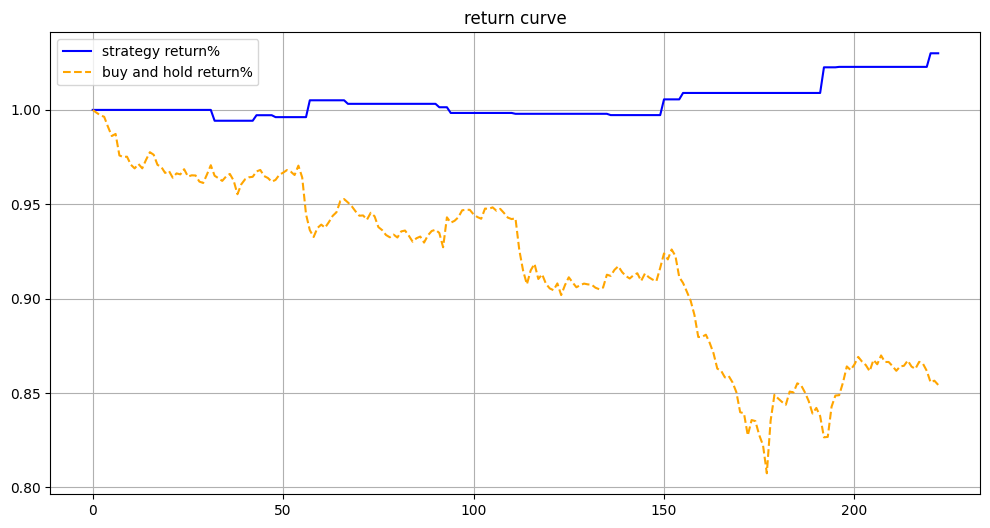

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假設 kline 已有 'close' 和 'signal'

# 初始化倉位：1=多, -1=空, 0=平倉
positions = kline['signal'].shift(1).fillna(0)  # shift(1) 表示信號在下一根K線才生效

# 計算每日報酬率
returns = positions * kline['close'].pct_change().fillna(0)

# 計算累積報酬
cumulative_returns = (1 + returns).cumprod()

# 畫圖
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label='strategy return%', color='blue')
plt.plot((1 + kline['close'].pct_change().fillna(0)).cumprod(), 
         label='buy and hold return%', color='orange', linestyle='--')
plt.title('return curve')
plt.legend()
plt.grid(True)
plt.show()

# topone退返70%報酬曲線

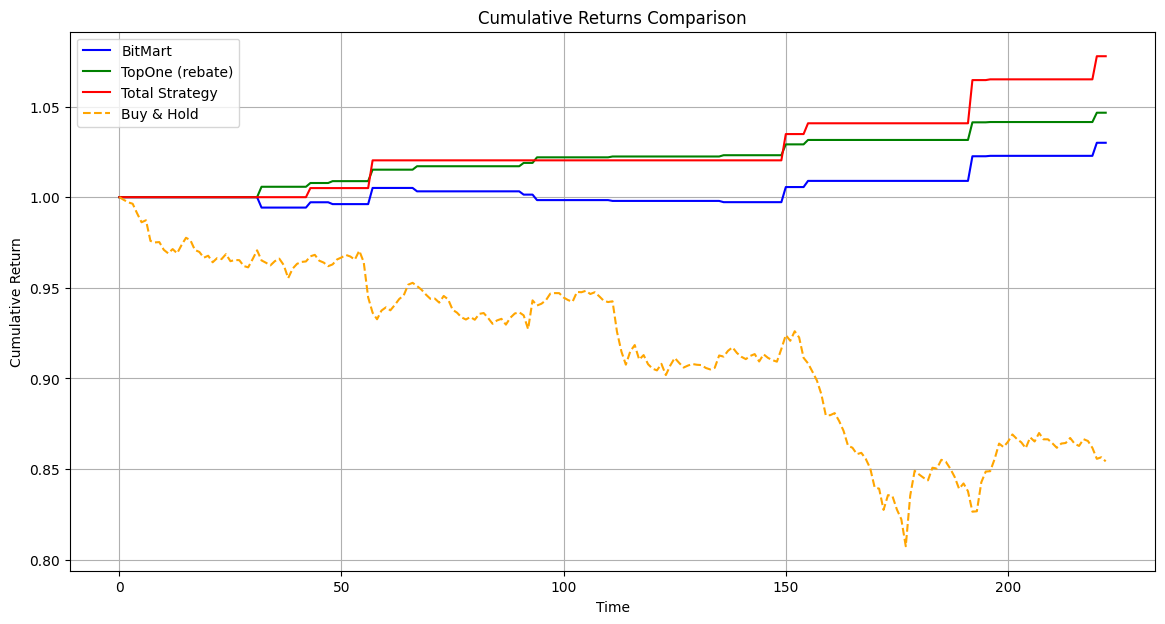

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假設 kline 已有 'close' 和 'signal'
positions = kline['signal'].shift(1).fillna(0)

# BitMart 單純按照信號報酬
bitmart_returns = positions * kline['close'].pct_change().fillna(0)
cumulative_bitmart = (1 + pd.Series(bitmart_returns)).cumprod()

# TopOne 對沖單（反向）
topone_returns = -bitmart_returns.copy()
# TopOne 返還機制：虧損單返還 70%
topone_returns = np.where(topone_returns < 0, topone_returns * -0.7, topone_returns)
cumulative_topone = (1 + pd.Series(topone_returns)).cumprod()

# 總報酬
strategy_returns = bitmart_returns + topone_returns
cumulative_strategy = (1 + pd.Series(strategy_returns)).cumprod()

# Buy & Hold
cumulative_bh = (1 + kline['close'].pct_change().fillna(0)).cumprod()

# 畫圖
plt.figure(figsize=(14,7))
plt.plot(cumulative_bitmart, label='BitMart', color='blue')
plt.plot(cumulative_topone, label='TopOne (rebate)', color='green')
plt.plot(cumulative_strategy, label='Total Strategy', color='red')
plt.plot(cumulative_bh, label='Buy & Hold', color='orange', linestyle='--')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


# 自動化交易

In [196]:
import time
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

while True:
    # 1️⃣ 取得最新 K 線
    kline = bitmart_client.get_kline_data('ETHUSDT', 15, start_time, int(time.time()))
    
    # 2️⃣ 計算 Voger 信號
    signals = voger_plus_signals(kline)
    print("📈 訊號為:", signals.iloc[-1])
    
    # 3️⃣ 取得最新價格
    current_price = bitmart_client.get_current_price('ETHUSDT')
    print("💰 目前價格為:", current_price)

    # 強制改成 1（測試用）
    signals.iloc[-1] = -1

    # 預設止盈止損
    tp_price = current_price * 1.02  # 止盈 2%
    sl_price = current_price * 0.98  # 止損 2%

    # 4️⃣ 執行下單
    if signals.iloc[-1] == 1:
        print("🟢 嘗試開多單...")
        response = bitmart_client.place_order(
            'ETHUSDT',
            'long',
            margin=5,
            leverage=5,
            tp_price=current_price * 1.02,
            sl_price=current_price * 0.98
        )
    elif signals.iloc[-1] == -1:
        print("🔴 嘗試開空單...")
        response = bitmart_client.place_order(
            'ETHUSDT',
            'short',
            margin=5,
            leverage=5,
            tp_price=current_price * 0.98,
            sl_price=current_price * 1.02
        )
    else:
        print("⚪ 無明確信號，不下單。")
        break

    # 5️⃣ 驗證下單回傳結果
    print("📤 下單回應:", response)

    try:
        # 有些 SDK 回傳 tuple (data, header)
        if isinstance(response, tuple):
            response_data = response[0]
        else:
            response_data = response

        # 驗證 code
        if response_data.get("code") == 1000:
            order_id = response_data["data"]["order_id"]
            print(f"✅ 下單成功，訂單 ID: {order_id}")
        else:
            raise ValueError(f"❌ 下單失敗，回應內容: {response_data}")
    except Exception as e:
        print(f"🚨 下單異常: {e}")
        # 可選：通知、重試、停止策略
        break

    #取得倉位
    position = bitmart_client.get_position('ETHUSDT')
    print("📄 目前倉位:", position)
    break

📈 訊號為: 0
💰 目前價格為: 3286.585
🔴 嘗試開空單...
📤 下單回應: ({'code': 1000, 'message': 'Ok', 'data': {'order_id': 3000237102956642, 'price': 'market price'}, 'trace': '04a8e707-cbfb-4c96-8340-dc959949691c'}, {'Remaining': '1', 'Limit': '24', 'Reset': '2', 'Mode': 'KEY'})
✅ 下單成功，訂單 ID: 3000237102956642
📄 目前倉位: {'symbol': 'ETHUSDT', 'leverage': '5', 'timestamp': 1762332469406, 'current_fee': '0.0000379', 'open_timestamp': 1762332469272, 'current_value': '23.00578', 'mark_price': '3286.64', 'position_value': '23.00053', 'position_cross': '4.6166663816', 'maintenance_margin': '0.0575162', 'close_vol': '0', 'close_avg_price': '0', 'open_avg_price': '3285.79', 'entry_price': '3285.79', 'current_amount': '7', 'unrealized_value': '-0.00525', 'realized_value': '-0.013800318', 'position_type': 2, 'margin_type': 'Isolated', 'mark_value': '23.00648', 'account': 'futures', 'position_mode': 'hedge_mode'}
